In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random


2022-01-05 21:04:07.841069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 21:04:07.841095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Task 1

In [2]:
n_timesteps_in = 50 # length of input sequence
n_timesteps_out = 40 # length of output sequence

n_features_in = 1
n_features_out = 1


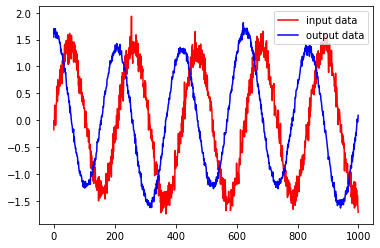

In [3]:


time_series_length = 1000
t = np.linspace(0, 10, time_series_length)
ts_input = np.sin(t) / 6 + 3 * np.sin(t*3) + 0.3 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 2 + 3 * np.cos(t*3) + 0.1 * np.random.standard_normal(size=time_series_length)
# normalize the data
ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()



In [4]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [5]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    # train data
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    # test data
    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)
        

In [6]:


train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()



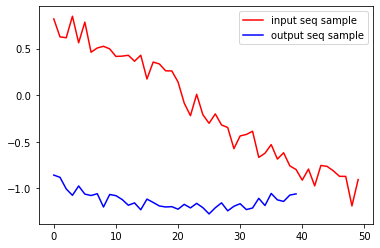

In [7]:


plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()



In [8]:


# reshape input to be [n_samples, n_time_steps, n_features]
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))



In [9]:
n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using 'encoder_states' as initial state.
decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

2022-01-05 21:05:53.702005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-05 21:05:53.702048: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-05 21:05:53.702080: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b2b9b6b183c4): /proc/driver/nvidia/version does not exist
2022-01-05 21:05:53.702444: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:


print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        66560       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [11]:
model.compile(optimizer='adam', loss='mse')

In [14]:


decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)



Epoch 1/100
7/7 - 0s - loss: 0.0303 - val_loss: 0.0336 - 380ms/epoch - 54ms/step
Epoch 2/100
7/7 - 0s - loss: 0.0348 - val_loss: 0.0243 - 363ms/epoch - 52ms/step
Epoch 3/100
7/7 - 0s - loss: 0.0304 - val_loss: 0.0307 - 366ms/epoch - 52ms/step
Epoch 4/100
7/7 - 0s - loss: 0.0322 - val_loss: 0.0233 - 357ms/epoch - 51ms/step
Epoch 5/100
7/7 - 0s - loss: 0.0264 - val_loss: 0.0280 - 370ms/epoch - 53ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0296 - val_loss: 0.0276 - 374ms/epoch - 53ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0264 - val_loss: 0.0220 - 360ms/epoch - 51ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0273 - val_loss: 0.0271 - 361ms/epoch - 52ms/step
Epoch 9/100
7/7 - 0s - loss: 0.0297 - val_loss: 0.0208 - 363ms/epoch - 52ms/step
Epoch 10/100
7/7 - 0s - loss: 0.0271 - val_loss: 0.0236 - 356ms/epoch - 51ms/step
Epoch 11/100
7/7 - 0s - loss: 0.0271 - val_loss: 0.0276 - 363ms/epoch - 52ms/step
Epoch 12/100
7/7 - 0s - loss: 0.0276 - val_loss: 0.0263 - 359ms/epoch - 51ms/step
Epoch 13/100
7/7 - 0s - l

In [15]:


decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])



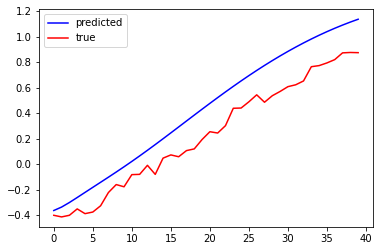

In [16]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()

# Task 2

In [138]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [190]:
d = cifar100.load_data()
# print(type(d))
# print(type(d[0][0]))

In [191]:


(x_train, y_train), (x_test, y_test) = cifar100.load_data()
# print(x_train.shape[0], 'train samples')
# print('image shape', x_train[0].shape)
# print(y_train[y_train==0])


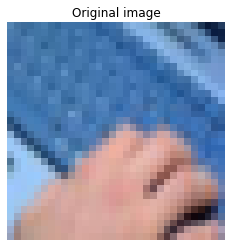

In [176]:
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(x_train[10])

In [192]:
# remove all but 3 classes
x_traine = np.ndarray(shape=(1500,32,32), dtype=float)
remove_idxs = np.isin(y_train, [i for i in range(3, 101)])
y_train = np.delete(y_train, remove_idxs.reshape(remove_idxs.shape[0]), axis=0)
x_train = np.delete(x_train, remove_idxs.reshape(remove_idxs.shape[0]), axis=0)
for i in range(len(x_train)):
    for j1 in range(len(x_train[i])):
        for j2 in range(len(x_train[i][j1])):
            x_train[i][j1][j2] = np.dot(x_train[i][j1][j2], [0.299, 0.587, 0.114])
            x_traine[i][j1][j2] = np.dot(x_train[i][j1][j2], [0.299, 0.587, 0.114])
#             print(np.dot(x_train[i][j1][j2], [0.299, 0.587, 0.114]), x_train[i][j1][j2])
x_train = x_traine

# remove_idxs_test = np.isin(y_test, [i for i in range(3, 101)])
# y_test = np.delete(y_test, remove_idxs_test.reshape(remove_idxs_test.shape[0]), axis=0)
# x_test = np.delete(x_test, remove_idxs_test.reshape(remove_idxs_test.shape[0]), axis=0)
# print(len(y_train), len(x_train), len(y_test), len(x_test))
# print(x_train.shape)

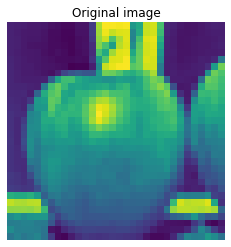

In [178]:
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(x_train[10])

In [179]:
input_dim = 32**2
x_train = x_train.reshape(1500, input_dim)
print('input shape: ', x_train.shape[1])
# print(x_train[:3])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]
# print(x_train[:3])

input shape:  1024


In [180]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
#     model.add(layers.Dense(1024, input_shape=(32,32,3), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
#     model.add(layers.Dense(input_dim, input_shape=(32,32,3), activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model  



In [181]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [185]:


def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 32, 32)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()



In [187]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
             # Generate fake CIRAF-100 images
            generated_images = generator.predict(noise)
            #print(generated_images.shape, image_batch.shape, x_train.shape)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0


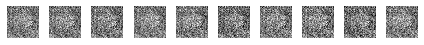

epoch:  20


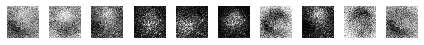

epoch:  40


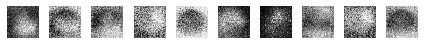

epoch:  60


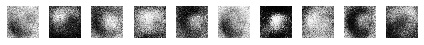

epoch:  80


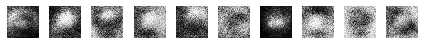

epoch:  100


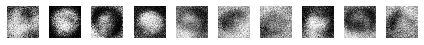

In [188]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

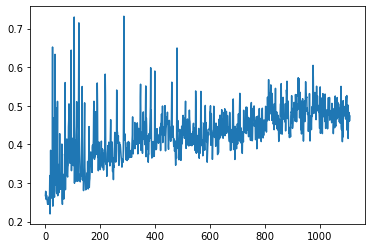

In [189]:
plt.plot(discrim_losses)